# Testing Mitiq ZNE in OpenQAOA

## Creation of the graph + QUBO model

In [1]:
def create_graph(nodes,edges):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
    return graph

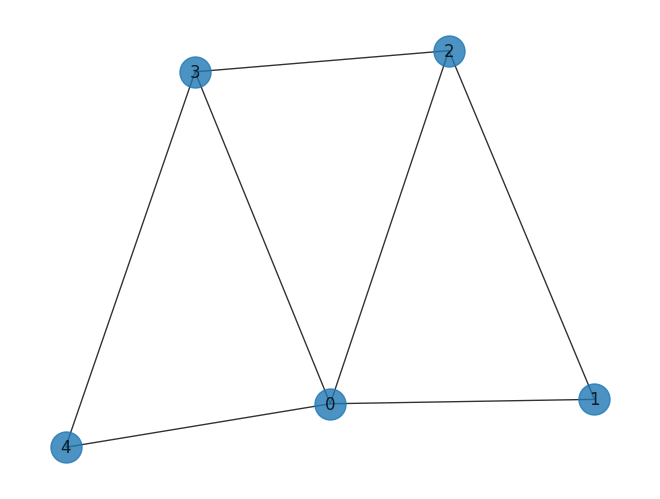

In [2]:
import networkx as nx
from openqaoa.problems import MaximumCut

G = create_graph(
[0, 1, 2, 3, 4, ],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
)

#Inner OpenQAOA function for ploting graphs
#plot_graph(graph)

# Create a MaximumCut instance from the graph and get its QUBO and hamiltonian
maxcut_prob = MaximumCut(G)
maxcut_qubo = maxcut_prob.qubo
maxcut_hamiltonian = maxcut_qubo.hamiltonian

## Creation of the QAOA + Mitiq ZNE class

In [3]:
from openqaoa import QAOA  
q = QAOA()
q

In [4]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q.set_device(qiskit_device)




## Adding a noise model

In [5]:
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
device_backend = FakeVigo()
device = QasmSimulator.from_backend(device_backend)
noise_model = NoiseModel.from_backend(device)


q.set_backend_properties(n_shots=1024, seed_simulator=1, noise_model = noise_model)

/tmp/ipykernel_71745/2383016634.py:1: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


## Requesting Mitiq ZNE mitigation and compiling

In [6]:
q.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q.compile(maxcut_qubo)

## Optimization

In [7]:
q.optimize()

## Getting the solution

In [12]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution = ground_state_hamiltonian(q.cost_hamil)
correct_solution

(-3.0,
 ['10100', '10010', '01010', '11010', '00101', '10101', '01101', '01011'])

## Comparing with standard QAOA, without noise

In [16]:
q1 = QAOA()
q1.set_device(qiskit_device)


q1.compile(maxcut_qubo)

In [17]:
q1.optimize()

In [18]:
correct_solution = ground_state_hamiltonian(q1.cost_hamil)
correct_solution

(-3.0,
 ['10100', '10010', '01010', '11010', '00101', '10101', '01101', '01011'])

## Comparing with standard QAOA, with IBM Quantum backend

In [5]:
from qiskit import IBMQ
from openqaoa import create_device
from qiskit_ibm_provider import IBMProvider

In [36]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
ibm_device = create_device(location='ibmq', 
                                name='simulator_stabilizer',
                                hub='ibm-q', 
                                group='open', 
                                project='main')

In [9]:
q2 = QAOA()
q2.set_device(ibm_device)
q2.compile(maxcut_qubo)

In [10]:
q2.optimize()

TranspilerError: "The number of qubits for Instruction(name='x', num_qubits=1, num_clbits=0, params=[]) does not match the number of qubits in the properties dictionary: (0, 1)"

In [ ]:
correct_solution = ground_state_hamiltonian(q2.cost_hamil)
correct_solution

## Comparing with OpenQAOA + Mitiq ZNE, with IBM Quantum backend

In [7]:
q3 = QAOA()
q3.set_device(ibm_device)
q3.set_backend_properties(n_shots=1024, seed_simulator=1)
q3.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q3.compile(maxcut_qubo)

In [8]:
q3.optimize()

TranspilerError: "The number of qubits for Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]) does not match the number of qubits in the properties dictionary: (0,)"

In [ ]:
correct_solution = ground_state_hamiltonian(q3.cost_hamil)
correct_solution

In [8]:
from openqaoa.backends.qaoa_backend import (
    DEVICE_NAME_TO_OBJECT_MAPPER,
    DEVICE_ACCESS_OBJECT_MAPPER,
)

In [9]:
print(DEVICE_NAME_TO_OBJECT_MAPPER.keys())

dict_keys(['vectorized', 'analytical_simulator', 'qiskit.qasm_simulator', 'qiskit.shot_simulator', 'qiskit.statevector_simulator'])
